In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path
import scipy.io

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

### Load data

In [2]:
# load input spike data
mat = scipy.io.loadmat(Path('data') / 'raw' / '01.mat') # animal 01

spike_train_all = mat['resp_train'] # spike train of all neurons, neurons x image x trials x milliseconds

images_all = mat['images'].squeeze()
images_all = torch.stack([torch.tensor(entry) for entry in images_all])

In [3]:
# only keep well-centered channels
indcent = mat['INDCENT'].squeeze()
spike_train_cent = torch.tensor(spike_train_all[indcent == 1]).float()

In [4]:
# get indices of all small natural images
idx_small_nat_images = torch.zeros(spike_train_all.shape[1], dtype=torch.bool)
idx_small_nat_images[:539:2] = 1
print(f'Number of small natural images: {torch.count_nonzero(idx_small_nat_images)}')

# get indices of all big natural images
idx_big_nat_images = torch.ones(spike_train_all.shape[1], dtype=torch.bool)
idx_big_nat_images[:539:2] = 0
idx_big_nat_images[540:] = 0
print(f'Number of big natural images: {torch.count_nonzero(idx_big_nat_images)}')

# get indices of all gratings
idx_gratings = torch.zeros(spike_train_all.shape[1], dtype=torch.bool)
idx_gratings[540:] = 1
print(f'Number of gratings: {torch.count_nonzero(idx_gratings)}')

Number of small natural images: 270
Number of big natural images: 270
Number of gratings: 416


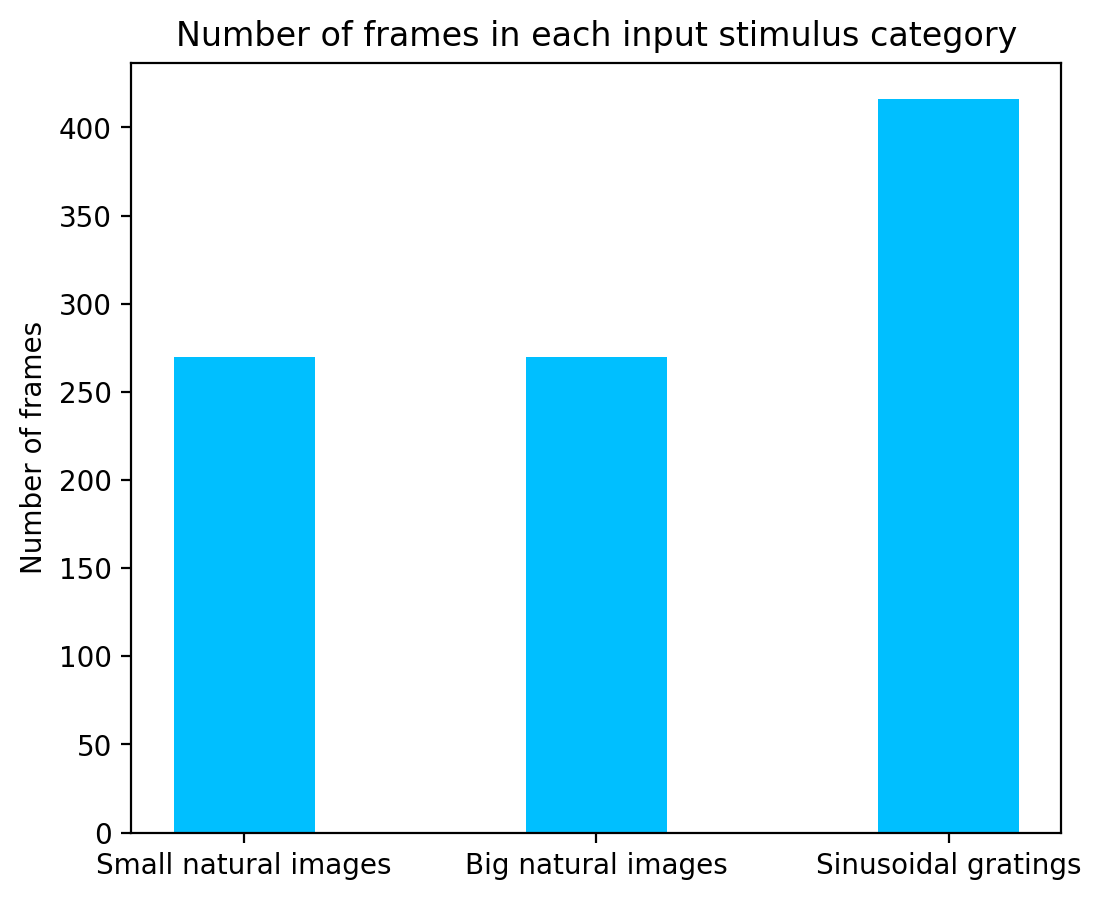

In [16]:
# create barplot
data = {'Small natural images': torch.count_nonzero(idx_small_nat_images),
        'Big natural images': torch.count_nonzero(idx_big_nat_images),
        'Sinusoidal gratings': torch.count_nonzero(idx_gratings)}

input_stimuli = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize = (6, 5))

# creating the bar plot
plt.bar(input_stimuli, values, color ='deepskyblue', 
        width = 0.4)

plt.ylabel('Number of frames')
plt.title('Number of frames in each input stimulus category')
plt.savefig(Path('figures') / 'data_distribution.png')
plt.show()

In [5]:
# only use gratings
spike_train_cent = spike_train_cent[:, idx_gratings, :, :]
images_all = images_all[idx_gratings, :, :]

### Generate train and test data (only for gratings)

In [6]:
n_images = len(images_all)
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

In [7]:
# generate shuffled indices
indices = np.arange(n_images)
np.random.shuffle(indices)

In [8]:
# compute split sizes
train_size = int(train_frac * n_images)
val_size = int(val_frac * n_images)
test_size = int(test_frac * n_images)

In [9]:
# split indices
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

In [10]:
# create boolean masks
train_mask = np.zeros(n_images, dtype=bool)
val_mask = np.zeros(n_images, dtype=bool)
test_mask = np.zeros(n_images, dtype=bool)

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

In [11]:
# create training, validation, and test sets
train_images = images_all[train_mask, :, :]
val_images = images_all[val_mask, :, :]
test_images = images_all[test_mask, :, :]

train_spikes = spike_train_cent[:, train_mask, :, :]
val_spikes = spike_train_cent[:, val_mask, :, :]
test_spikes = spike_train_cent[:, test_mask, :, :]

In [12]:
# save files
save_dir = Path('data')

torch.save(train_images, Path(save_dir) / 'train_images_gratings.pt')
torch.save(val_images, Path(save_dir) / 'val_images_gratings.pt')
torch.save(test_images, Path(save_dir) / 'test_images_gratings.pt')

torch.save(train_spikes, Path(save_dir) / 'train_spikes_gratings.pt')
torch.save(val_spikes, Path(save_dir) / 'val_spikes_gratings.pt')
torch.save(test_spikes, Path(save_dir) / 'test_spikes_gratings.pt')